# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

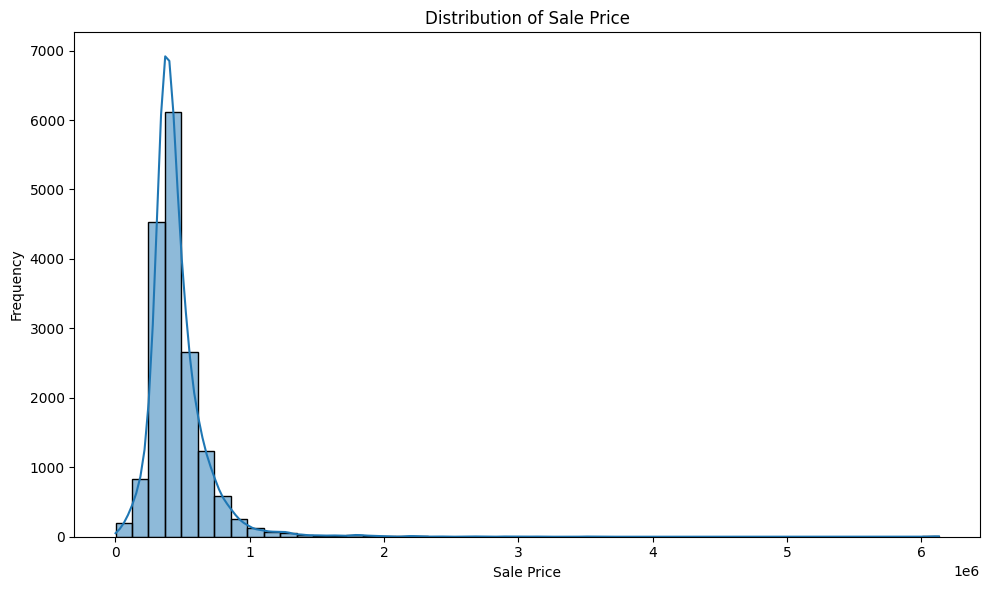

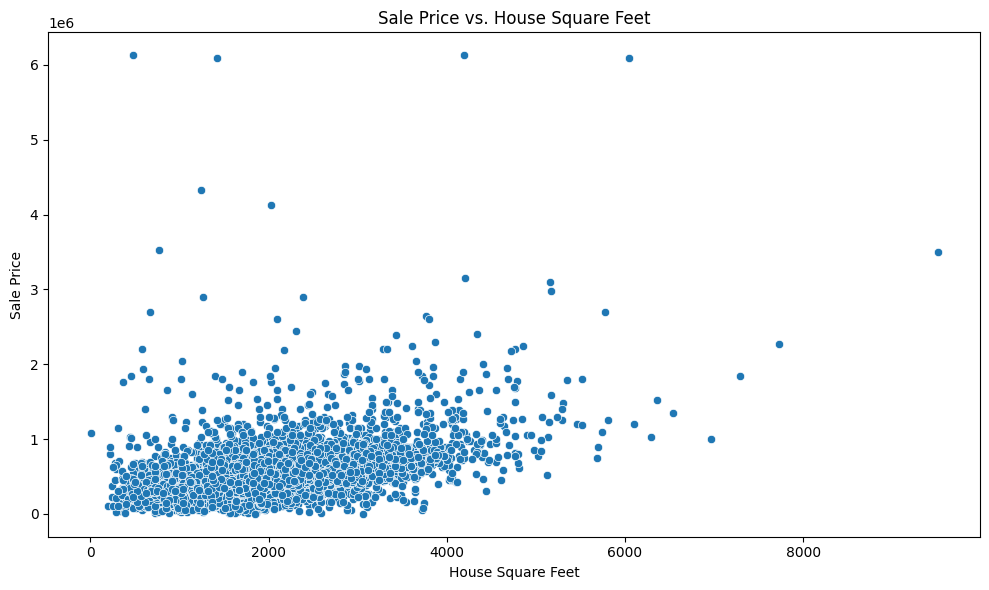

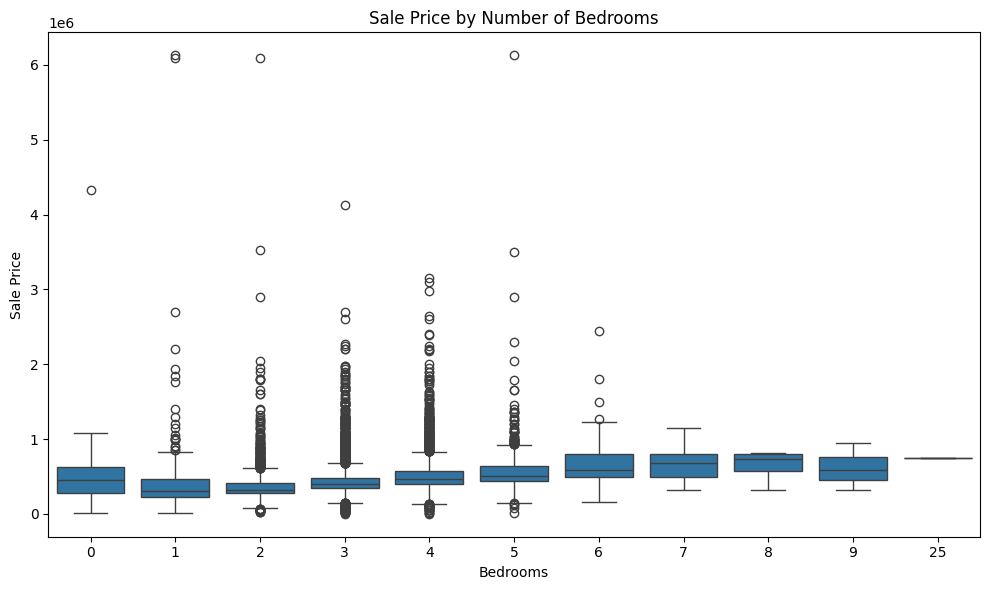

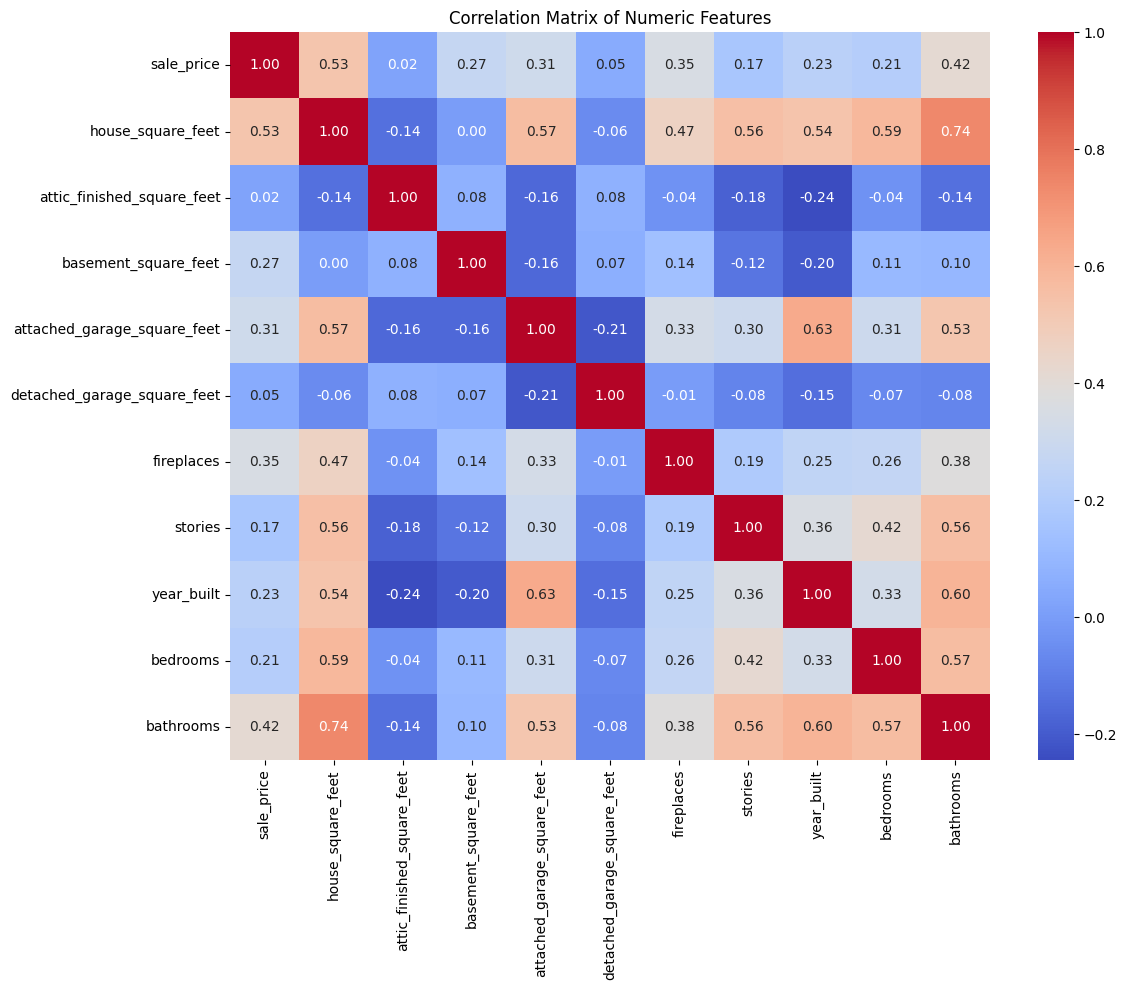

Simple Linear Model:
Train RMSE: 177707.52
Test RMSE: 168620.14
Train R²: 0.432
Test R²: 0.451


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


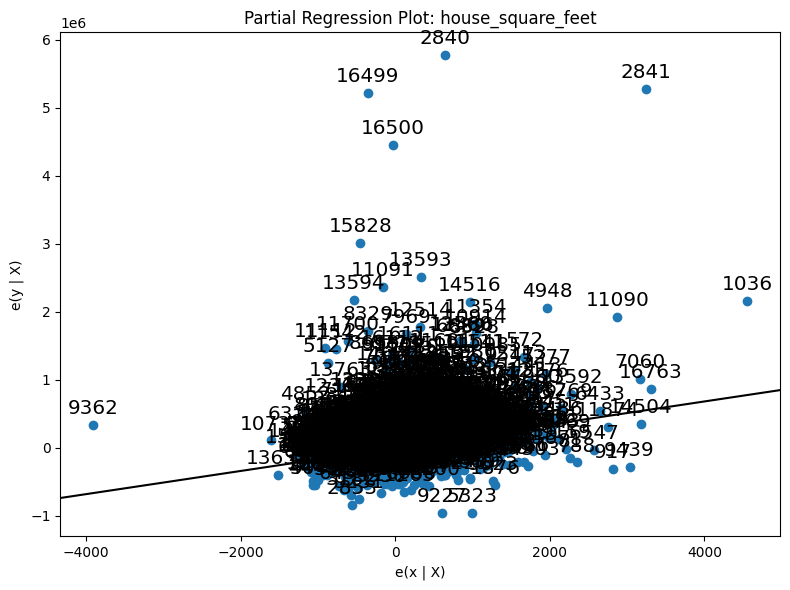

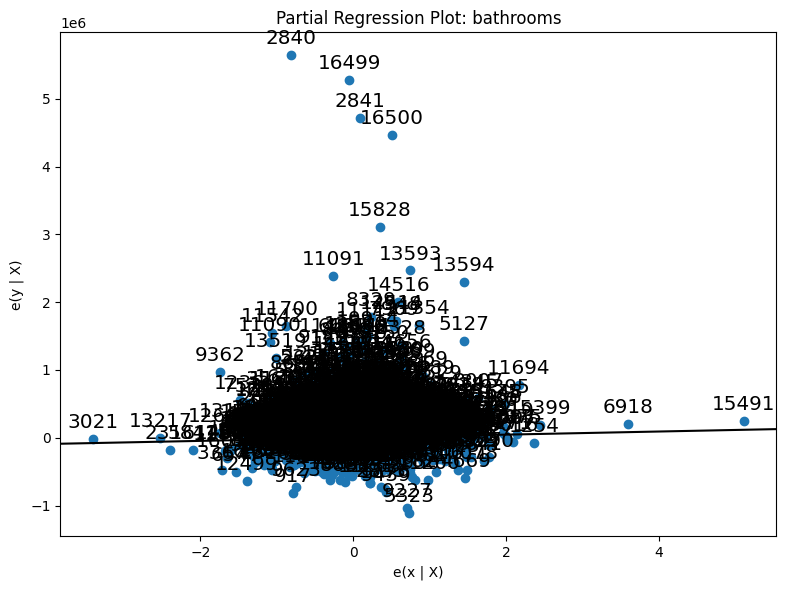

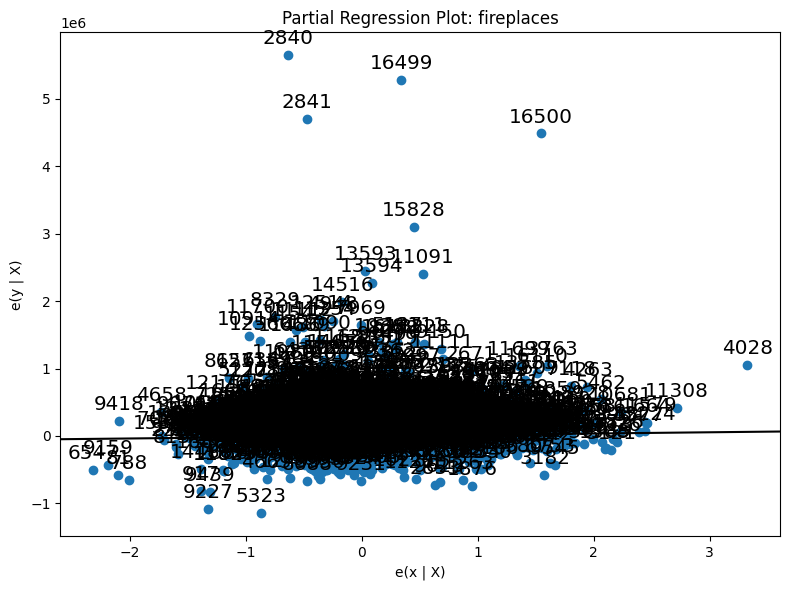

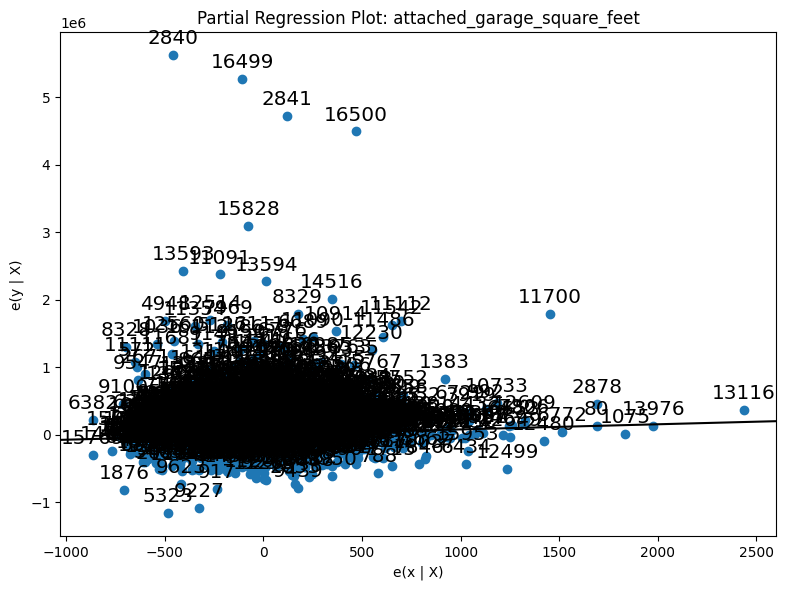

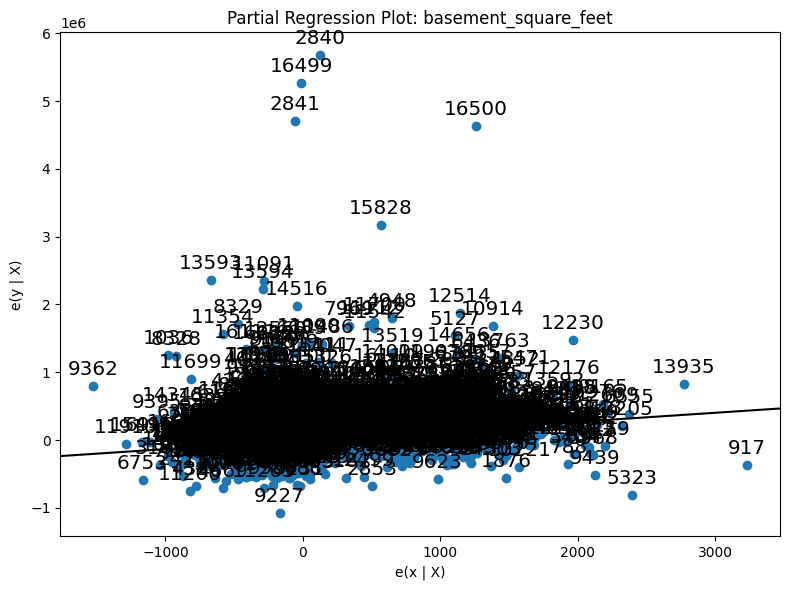

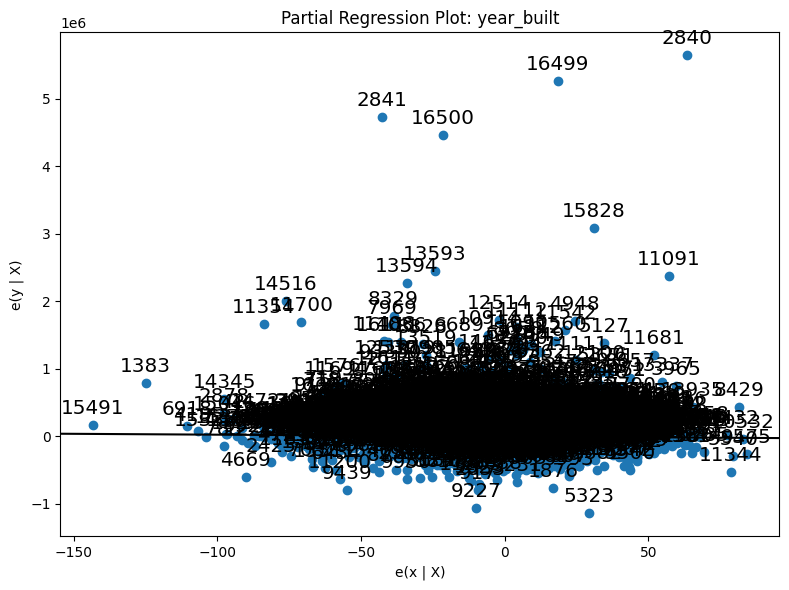

Polynomial Model (degree 2):
Train RMSE: 150994.27
Test RMSE: 564961.77
Train R²: 0.590
Test R²: -5.158
Lasso Model:
Train RMSE: 187258.73
Test RMSE: 176374.36
Train R²: 0.369
Test R²: 0.400

Top selected features by Lasso:
attic_finished_square_feet     180.874821
basement_square_feet           153.025283
house_square_feet              148.784645
detached_garage_square_feet    108.596538
attached_garage_square_feet     96.786049
year_built                     -22.828358
dtype: float64


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV

import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid

# loading data
df = pd.read_csv('/content/pierce_county_house_sales.csv')

# convert sale_date to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])

# drop rows with missing categorical values
cat_cols = ['hvac_description', 'exterior', 'interior', 'roof_cover', 'utility_sewer']
df = df.dropna(subset=cat_cols)

# summary statistics
summary_stats = df.describe(include='all')

# plot: sale price
plt.figure(figsize=(10, 6))
sns.histplot(df['sale_price'], bins=50, kde=True)
plt.title("Distribution of Sale Price")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# plot: Sale Price vs. House Square Feet
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='house_square_feet', y='sale_price')
plt.title("Sale Price vs. House Square Feet")
plt.xlabel("House Square Feet")
plt.ylabel("Sale Price")
plt.tight_layout()
plt.show()

# plot: Sale Price by Number of Bedrooms
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='bedrooms', y='sale_price')
plt.title("Sale Price by Number of Bedrooms")
plt.xlabel("Bedrooms")
plt.ylabel("Sale Price")
plt.tight_layout()
plt.show()

# plot: Correlation heatmap for numerical features
plt.figure(figsize=(12, 10))
numeric_features = df.select_dtypes(include='number')
sns.heatmap(numeric_features.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()


# cleaning the data
# safely drop columns only if they exist
cols_to_drop = ['view_quality', 'waterfront_type']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# simple linear model
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# separate features/target
X = df_encoded.drop(columns=['sale_price', 'sale_date'])
y = df_encoded['sale_price']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

print("Simple Linear Model:")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_preds)):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f}")
print(f"Train R²: {r2_score(y_train, train_preds):.3f}")
print(f"Test R²: {r2_score(y_test, test_preds):.3f}")

# clean up X and Y
X_train_clean = X_train.copy()
X_train_clean.columns = [col.replace(" ", "_").replace("/", "_").replace("-", "_") for col in X_train_clean.columns]
X_train_clean = X_train_clean.astype(np.float64)
X_train_clean = sm.add_constant(X_train_clean)

y_train_clean = y_train.loc[X_train_clean.index].astype(np.float64)

# partial regression plots
from statsmodels.graphics.regressionplots import plot_partregress
import matplotlib.pyplot as plt

top_features = X_train_clean.corrwith(y_train_clean).abs().sort_values(ascending=False).head(6).index.drop('const', errors='ignore')

for column in top_features:
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_partregress(endog='sale_price', exog_i=column,
                     exog_others=X_train_clean.drop(columns=[column]),
                     data=pd.concat([y_train_clean.rename('sale_price'), X_train_clean], axis=1),
                     ax=ax)
    ax.set_title(f"Partial Regression Plot: {column}")
    plt.tight_layout()
    plt.show()

# complex model with polynomial features
poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
poly_model.fit(X_train, y_train)

poly_train_preds = poly_model.predict(X_train)
poly_test_preds = poly_model.predict(X_test)

print("Polynomial Model (degree 2):")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, poly_train_preds)):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, poly_test_preds)):.2f}")
print(f"Train R²: {r2_score(y_train, poly_train_preds):.3f}")
print(f"Test R²: {r2_score(y_test, poly_test_preds):.3f}")

# reguralization with lasso
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train, y_train)

lasso_train_preds = lasso.predict(X_train)
lasso_test_preds = lasso.predict(X_test)

print("Lasso Model:")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, lasso_train_preds)):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, lasso_test_preds)):.2f}")
print(f"Train R²: {r2_score(y_train, lasso_train_preds):.3f}")
print(f"Test R²: {r2_score(y_test, lasso_test_preds):.3f}")

# most important features
lasso_features = pd.Series(lasso.coef_, index=X.columns)
important_features = lasso_features[lasso_features != 0].sort_values(ascending=False)

print("\nTop selected features by Lasso:")
print(important_features.head(10))

Sale prices were right-skewed, with most homes priced under $600k and a few high-end outliers. House square footage and garage size showed strong positive correlations with price, while bedroom count had a weaker, overlapping relationship. A simple linear regression model showed decent performance but slight overfitting. Partial regression plots for the top features confirmed mostly linear relationships, with no major non-linear patterns observed